In [1]:
import torch 
from torch import optim
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from datasets import COCOADatasetGraph, COCOADatasetDual

from Trainer import MaskTrainer, DualMaskTrainer
from UNet import UNet, UNetDual

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
DUAL = False # Dual segmentation + graph output
C = 8        # Number of channels in graph

# Data

In [3]:
def COCOADataset(phase, transform=None):
    root_dict = {'train': "../data/COCOA/train2014", 'val': "../data/COCOA/val2014"}
    img_root = root_dict[phase]
    annot_path = "../data/COCOA/annotations/COCO_amodal_{}2014.json".format(phase)
    graph_root = "../data/COCOA/pixel_graphs_{}/".format(phase)
    if DUAL:
        return COCOADatasetDual(annot_path, img_root, graph_root, transform=transform)
    else:
        return COCOADatasetGraph(annot_path, img_root, graph_root, transform=transform)

# Training

In [4]:
model = UNet(out_channels=C) if not DUAL else UNetDual(seg_out_channels=91, graph_out_channels=C)
model = model.to(device)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(300),
    transforms.RandomCrop(256)
])

train_dataset = COCOADataset('train', transform=transform)
val_dataset = COCOADataset('val', transform=transform)

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if DUAL:
    trainer = DualMaskTrainer(device, model, train_dataset, val_dataset, 32, optimizer, scheduler=scheduler, 
                              losses=[nn.CrossEntropyLoss(), nn.MSELoss()], alpha=0.5, num_workers=2, exp_name='unet')
else:
    trainer = MaskTrainer(device, model, train_dataset, val_dataset, 24, optimizer, scheduler=scheduler, 
                          loss=nn.CrossEntropyLoss(), num_workers=2, exp_name='unet')

In [7]:
train_log = trainer.train(10, checkpoint=False)

  0%|          | 0/105 [00:03<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 6.00 GiB total capacity; 4.25 GiB already allocated; 0 bytes free; 4.34 GiB reserved in total by PyTorch)

# Results

In [33]:
def plot_predictions(img, graph_pred, graph_target):
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(graph_target.transpose(1, 2, 0)[:, :, 0])
    plt.title("GT Graph 0")
    plt.subplot(1, 3, 3)
    plt.imshow(graph_pred.transpose(1, 2, 0)[:, :, 0])
    plt.title("Pred Graph 0")
    plt.show()
    
def plot_predictions_dual(img, graph_pred, graph_target, seg_pred, seg_target):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input")
    plt.subplot(1, 5, 2)
    plt.imshow(graph_target.transpose(1, 2, 0)[:, :, 0])
    plt.title("GT Graph 0")
    plt.subplot(1, 5, 3)
    plt.imshow(graph_pred.transpose(1, 2, 0)[:, :, 0])
    plt.title("Pred Graph 0")
    plt.subplot(1, 5, 4)
    plt.imshow(seg_target.transpose(1, 2, 0))
    plt.title("GT Segmentation")
    plt.subplot(1, 5, 5)
    plt.imshow(seg_pred.transpose(1, 2, 0)[:, :, 0])
    plt.title("Pred Segmentation")
    plt.show()

In [34]:
batch = next(iter(trainer.val_loader))
if DUAL:
    img, (seg_gt, graph_gt), _ = batch
    graph_gt = graph_gt.numpy()
    seg_gt = seg_gt.numpy()
    seg_pred, graph_pred = trainer.evaluate(batch)
else:
    img, gt, _ = batch
    gt = gt.numpy()
    graph_pred = trainer.evaluate(batch)

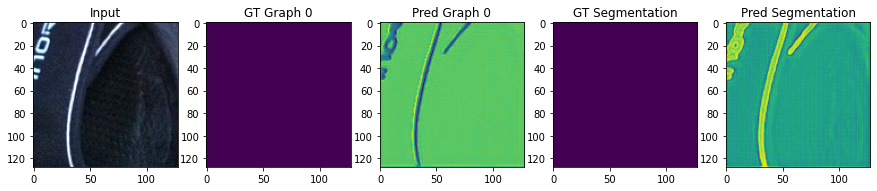

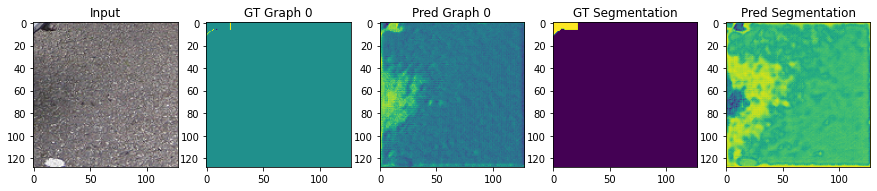

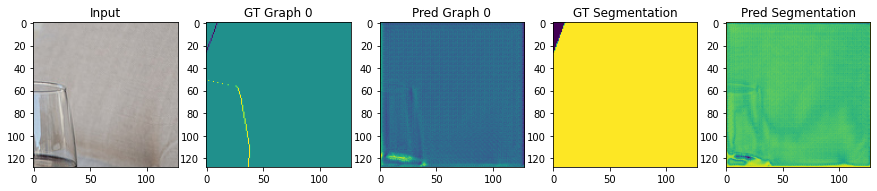

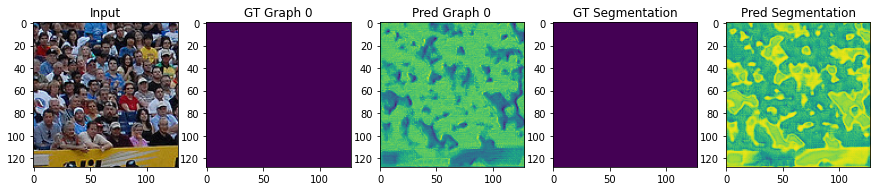

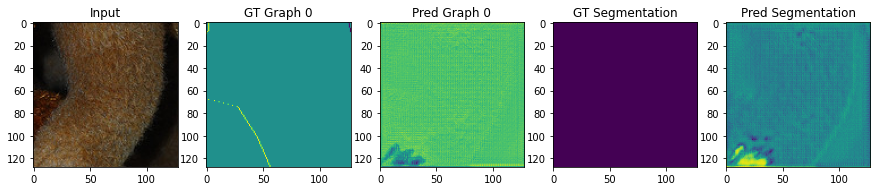

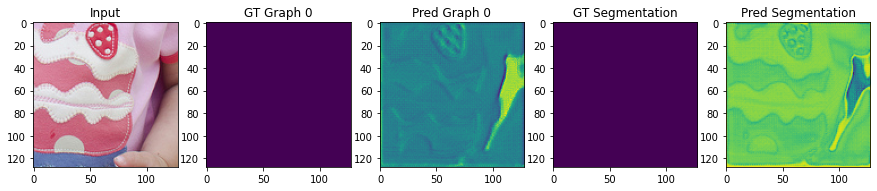

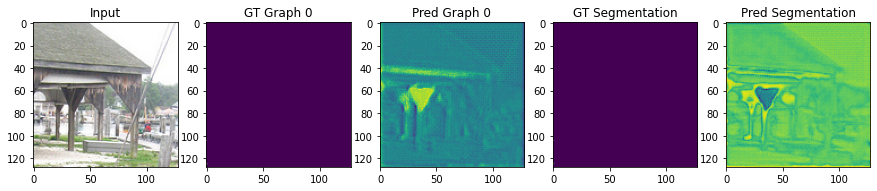

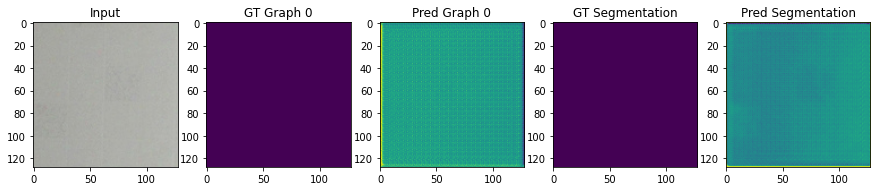

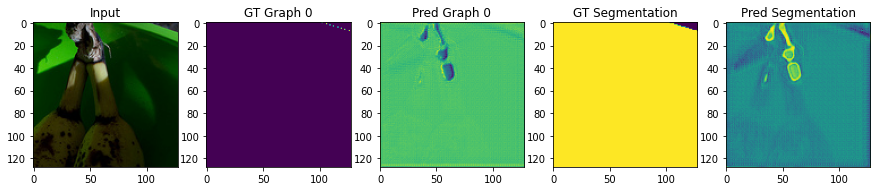

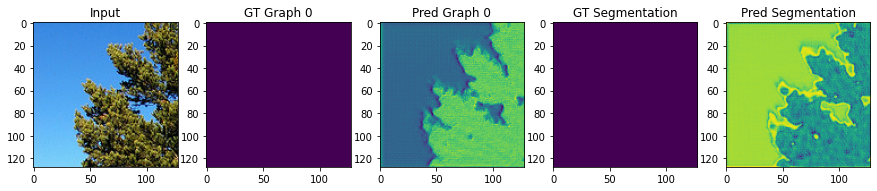

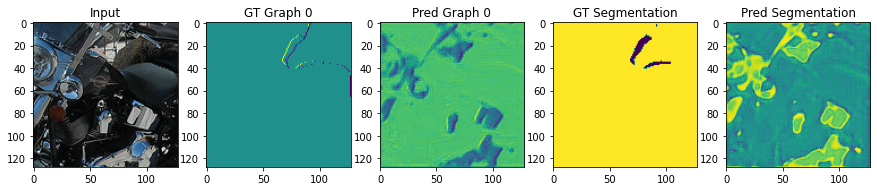

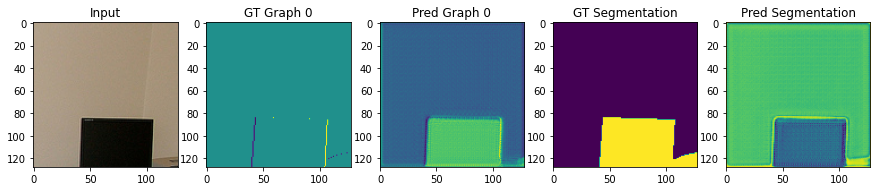

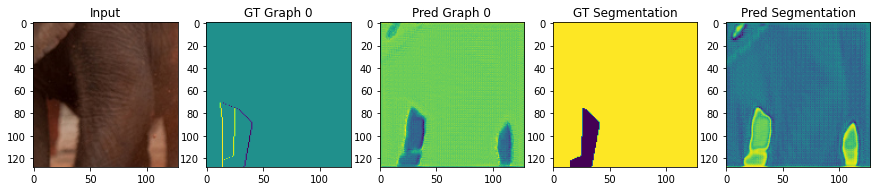

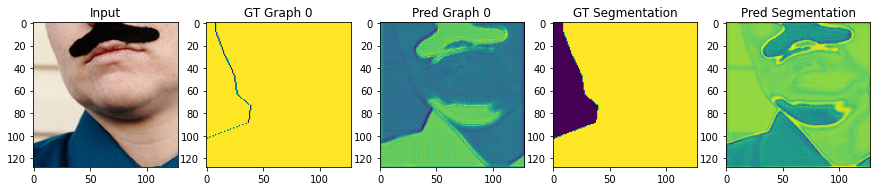

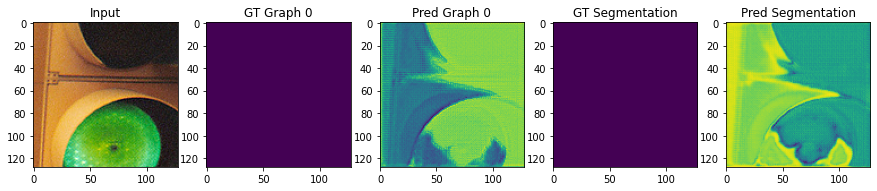

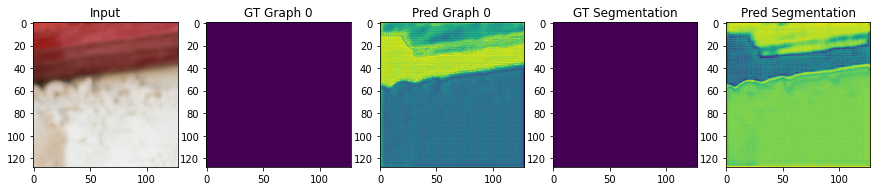

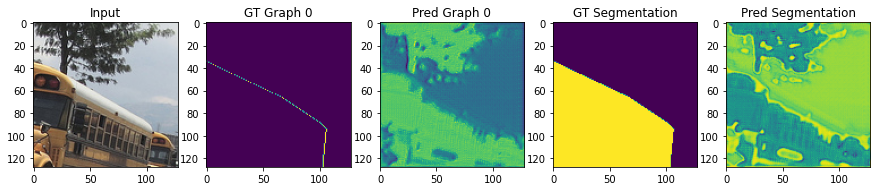

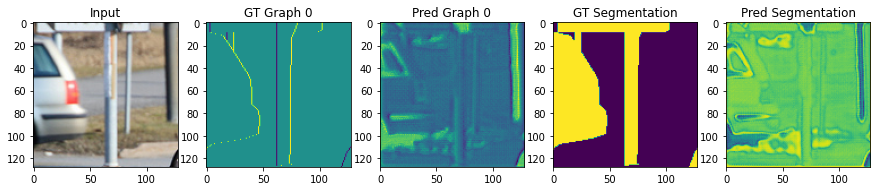

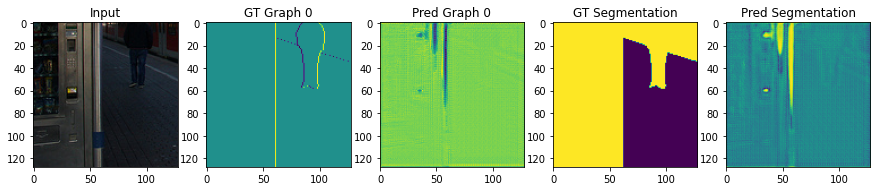

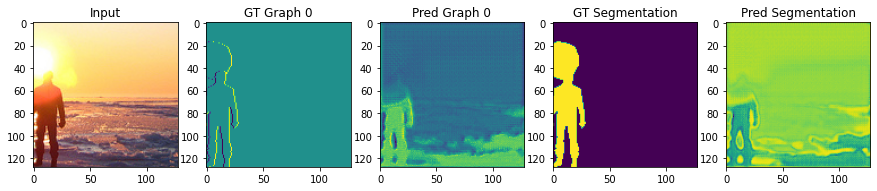

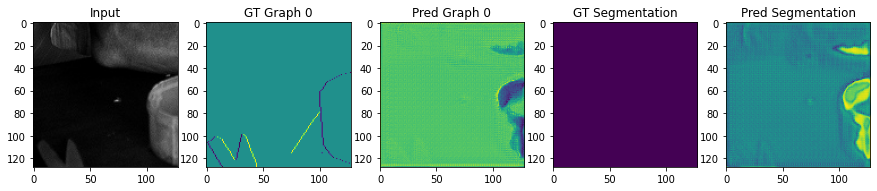

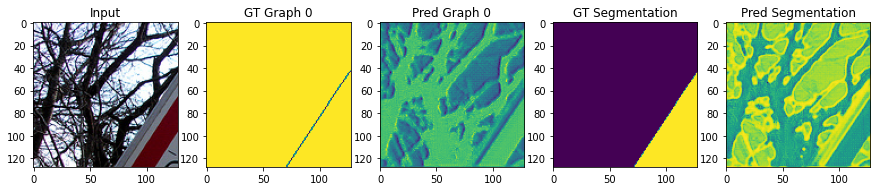

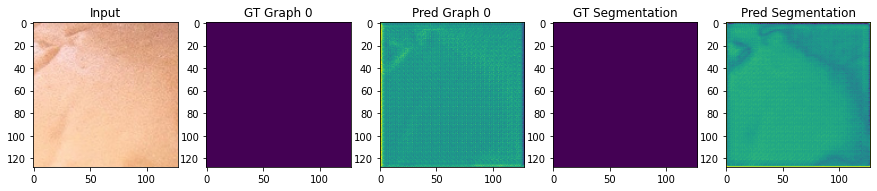

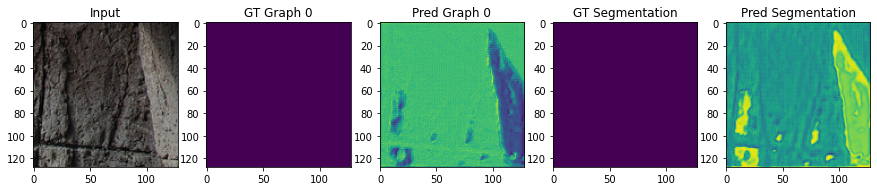

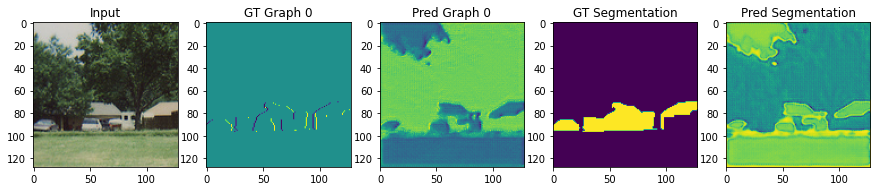

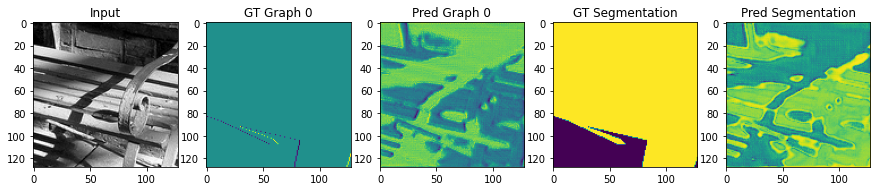

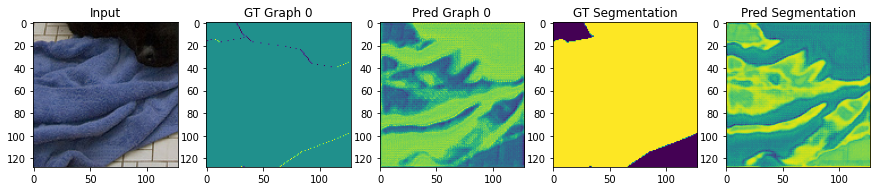

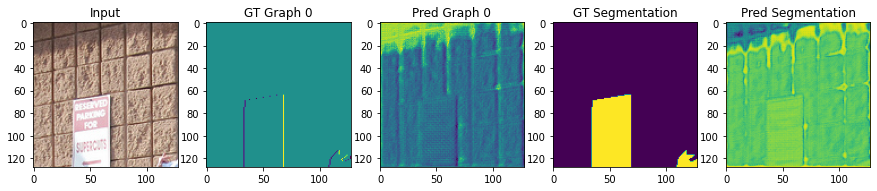

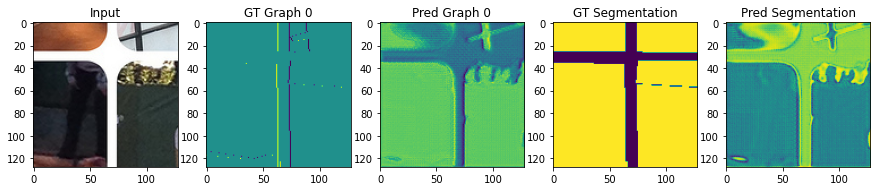

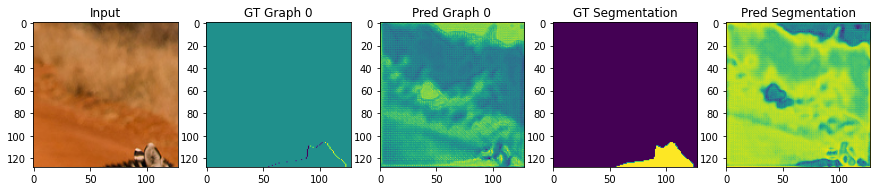

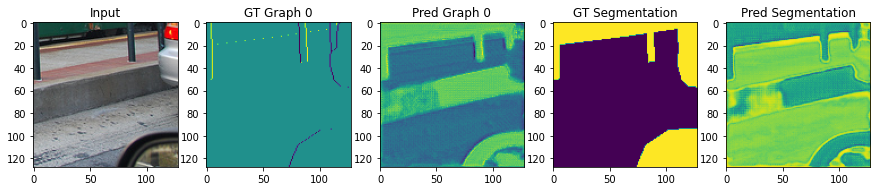

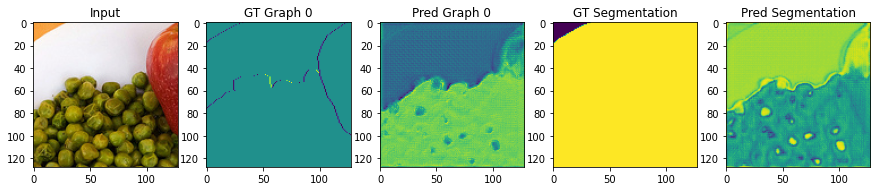

In [35]:
for i in range(len(img)):
    if DUAL:
        plot_predictions_dual(img[i], graph_pred[i], graph_gt[i], seg_pred[i], seg_gt[i])
    else:
        plot_predictions(img[i], graph_pred[i], gt[i])

In [38]:
torch.flatten([[0, 1], [2, 3]], start_dim=1)

TypeError: flatten(): argument 'input' (position 1) must be Tensor, not list